## Problem statement:
WTWY needs to optimize their street teams so that they can get the most email signups for their annual OMGYN Gala. Ideally, the email signups will convert at a high rate to gala attendees, and among attendees, many will make contributions to WTWY.

MTA data obtained from the NYC Data Portal provides rich information about the travel patterns of New Yorkers -- using this information, can we create a street team deployment plan that will optimize WTWY’s resources toward achieving their goals?

Import useful libaries for analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
%matplotlib inline

Below are a few functions that will help us conveniently download the data from the MTA website

In [4]:
def read_MTA_data(list_of_dates):
    '''
    1. Takes a list of dates in the form of 'yymmdd' and 
    extracts the .txt file corresponding to the dates 
    from 'http://web.mta.info/developers/turnstile.html.'
    
    2. Converts each extraction to a csv file
    
    3. Concatenates all the csv files into a single dataframe
    '''
    # Initiate an empty dataframe 
    combined_df = pd.DataFrame()
    
    root_url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
    
    # loop through the url links and concatenate all the data set into a one
    for date in list_of_dates:
        # represents a url link matching each date provided
        MTA_url = f'{root_url}{date}.txt'
        # converts the url into csv file 
        dataset = pd.read_csv(MTA_url)
        # concatenate the obtained dataset to the overall dataframe
        combined_df = pd.concat([combined_df, dataset], ignore_index = True)
    
    return combined_df

In [5]:
def all_SAT(year):
    '''
    Takes in a year yyyy and returns all the saturdays in yyyy
    in the format of yymmdd
    '''
    return pd.date_range(start=str(year), end=str(year+1), 
                         freq='W-SAT').strftime('%y%m%d').tolist()

In [6]:
def month_filter(list_of_dates, list_of_months):
    
    '''
    Takes a list of dates in format yymmdd and a list of months in format mm
        - The list_of_months contains the months of interest
    
    Returns a list of dates from the list list_of_dates that only contains
    the months of interest
    '''
    
    # Initial an empty list of dates
    dates_for_months = []
    for month in list_of_months:
        # return the dates containing the months of interest in list_of_dates
        filtered_dates = list(filter(lambda x: (x[2:4] in month), list_of_dates))
        dates_for_months += filtered_dates
    
    return dates_for_months

Import MTA data for the months of April, May, June of 2019

Since the DataFrame is fairly large, we will use pickle to save it to bytes.

In [ ]:
# Create a list of dates (SATURDAY) for the year of 2019
sat_2019 = all_SAT(2019)

# Filter the year to only April, May, and June
months_of_interest = ['04', '05', '06']
april_may_june_2019 = month_filter(sat_2019, months_of_interest)

# Read each date into a combined dataframe using read_MTA_data containing April, May, and June of 2019
summer19_MTA = read_MTA_data(april_may_june_2019)
summer19_MTA.head(25)

In [8]:
import pickle 

with open('summer19_MTA.pickle', 'wb') as to_write:
    pickle.dump(summer19_MTA, to_write)

Now the DataFrame is saved into bytes. We can open it with without having to run previous cells.

In [7]:
with open('summer19_MTA.pickle', 'rb') as to_read:
    summer19_MTA = pickle.load(to_read)

In [8]:
summer19_MTA.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,00:00:00,REGULAR,6999064,2373568
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,08:00:00,REGULAR,6999107,2373622
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,12:00:00,REGULAR,6999214,2373710
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,16:00:00,REGULAR,6999451,2373781


In [9]:
summer19_MTA.info()
print(f'We have a total of {np.shape(summer19_MTA)[0]} data points')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664248 entries, 0 to 2664247
Data columns (total 11 columns):
C/A                                                                     object
UNIT                                                                    object
SCP                                                                     object
STATION                                                                 object
LINENAME                                                                object
DIVISION                                                                object
DATE                                                                    object
TIME                                                                    object
DESC                                                                    object
ENTRIES                                                                 int64
EXITS                                                                   int64
dtypes: int64(2), ob

In [10]:
# Let's examine the column names
summer19_MTA.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

Eliminate column name mistakes such as 'EXITS         '

In [11]:
# Use string method strip to eliminate all spacings before and after in a string.
summer19_MTA.columns = summer19_MTA.columns.str.strip()

Make Unique Station names with combination of STATION and LINENAME

In [12]:
summer19_MTA['Unique_Station'] = summer19_MTA['STATION'] + '_' + summer19_MTA['LINENAME']

Since the ENTRIES and EXITS are accumulations of traffic per every 4 hours, we create two columns that accounts for the differences to track the actual number of entires and exits.

In addition, we will treat the sum of number of entries and exits in a specifc station to be our total traffic for that station.

In [13]:
summer19_MTA['ENTRIES DIFF'] = summer19_MTA['ENTRIES'].diff()
summer19_MTA['EXITS DIFF'] = summer19_MTA['EXITS'].diff()
summer19_MTA['Total_Traffic'] = summer19_MTA['ENTRIES DIFF'] + summer19_MTA['EXITS DIFF']

We want to convert the date to the day of the week

In [14]:
import datetime
import calendar

def findDay(date): 
    
    '''
    grabs the data in the format mm/dd/yy 
    and returns the day of the week
    '''
    mmddyy = datetime.datetime.strptime(date, '%m/%d/%Y').weekday() 
    return (calendar.day_name[mmddyy]) 

Create a new column to indicate what day of the week it is. We can use this information later.

In [15]:
summer19_MTA['DAY_OF_WEEK'] = summer19_MTA['DATE'].apply(lambda date: findDay(date))

Let's group by each unique station and sum the total traffic in April, May, and June of 2019

In [16]:
summer19_MTA.groupby('Unique_Station').sum().head(10)

,ENTRIES,EXITS,ENTRIES DIFF,EXITS DIFF,Total_Traffic
Unique_Station,,,,,
1 AV_L,799849750681,828041356350,-5.677284e+07,-9.944337e+07,-1.562162e+08
103 ST-CORONA_7,39770511766,40001193343,5.963920e+07,1.046125e+08,1.642517e+08
103 ST_1,36123986643,19507779049,1.471258e+08,1.387234e+08,2.858493e+08
103 ST_6,283467824157,507193667658,-3.908337e+09,3.902927e+09,-5.409978e+06
103 ST_BC,16335771399,14068256692,6.274388e+07,1.079485e+08,1.706924e+08
104 ST_A,929908198748,544226211876,2.181723e+10,1.271053e+10,3.452776e+10
104 ST_JZ,1715206978839,1385219485966,4.322307e+07,5.862511e+07,1.018482e+08
110 ST_6,21024033135,20218237598,-4.293304e+09,-3.844511e+09,-8.137816e+09
111 ST_7,28809071524,17589378769,-2.965029e+06,-4.931508e+07,-5.228011e+07


Some of the total traffic for each unique station are negative which does not make senses. We need to investigate why this is the case.

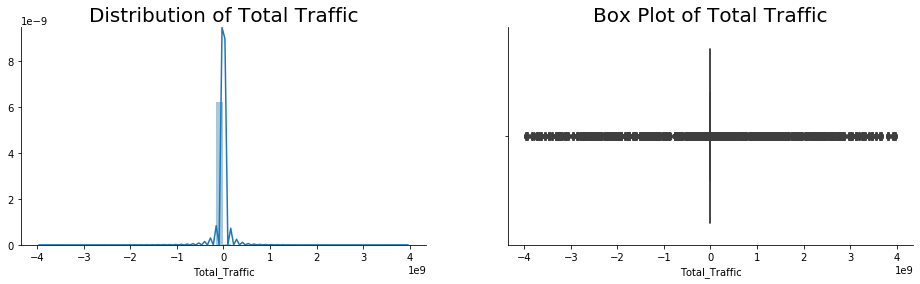

In [17]:
plt.figure(figsize = [16,4])
plt.subplot(1,2,1)
sns.distplot(summer19_MTA['Total_Traffic'][1:]);
plt.title('Distribution of Total Traffic', size = 20);
plt.subplot(1,2,2)
sns.boxplot(summer19_MTA.Total_Traffic[1:]);
plt.title('Box Plot of Total Traffic', size = 20);
sns.despine()
plt.savefig('Initial Distribution Plots.png')

Plotting the distribution and box plot, we can see that we have some very large positive values or very large negative values. We need to filter down the values to something that makes sense.

1. we should remove all negative traffic
2. We can calculate the IQR for total traffic per four hours per scp to use as our mask filter.

In [18]:
# remove all negative traffic
mask = summer19_MTA['Total_Traffic'] > 0
summer19_MTA_pos = summer19_MTA[mask]

print(f'We have a total of {np.shape(summer19_MTA)[0]} data points')

We have a total of 2664248 data points


In [19]:
# calculate the 25th, 50th, and 75th quartiles
q25, q50, q75 = np.percentile(summer19_MTA.Total_Traffic[1:], [25, 50, 75])

# interquartile range use to calculate the max and min values from the data set
IQR = q75 - q25

# calculate the min and max values. Anything outside these values are outliers.
min_traffic = q25 - (1.5 * IQR)
max_traffic = q75 + (1.5 * IQR)

print(min_traffic, max_traffic)

-627.5 1112.5


Filter out all the outliers based on the IQR calculated above on the total traffic

In [20]:
total_traffic_mask = ((summer19_MTA_pos['Total_Traffic'] > min_traffic) & (summer19_MTA_pos['Total_Traffic'] < max_traffic))
summer19_MTA_cleaned = summer19_MTA_pos[total_traffic_mask]

print(f'We have a total of {np.shape(summer19_MTA_cleaned)[0]} data points')

We have a total of 2135517 data points


Using a logic mask with the max total traffic per SCP to be 1 second per person.

total_traffic_mask = ((summer19_MTA['Total_Traffic'] > 0) & (summer19_MTA['Total_Traffic'] < 30000))
summer19_MTA_cleaned = summer19_MTA[total_traffic_mask]
print(f'We have a total of {np.shape(summer19_MTA_cleaned)[0]} data points')

We will examine the distribution and box plot again after the filter

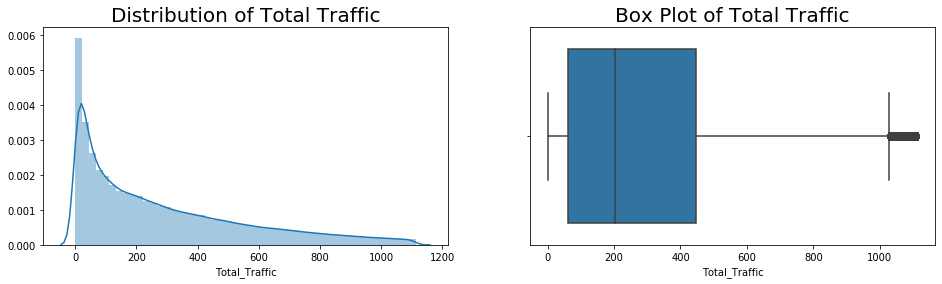

In [21]:
plt.figure(figsize = [16,4])

plt.subplot(1,2,1)
sns.distplot(summer19_MTA_cleaned.Total_Traffic);
plt.title('Distribution of Total Traffic', size = 20);

plt.subplot(1,2,2)
sns.boxplot(summer19_MTA_cleaned.Total_Traffic);
plt.title('Box Plot of Total Traffic', size = 20);
plt.savefig('Distribution after filter.png')

We should normalize the total_traffic since the goal is to find the top stations. Large numbers presents problems in terms of visualizing them on graphs

In [22]:
# tt = Total Traffic

tt_min = summer19_MTA_cleaned['Total_Traffic'].min()
tt_max = summer19_MTA_cleaned['Total_Traffic'].max()

summer19_MTA_cleaned['Total_Traffic'] = (summer19_MTA_cleaned.Total_Traffic - tt_min) / (tt_max - tt_min)

/Users/bentleyou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Distribution of after normalization. The total traffic per time slot should be between 0 and 1.

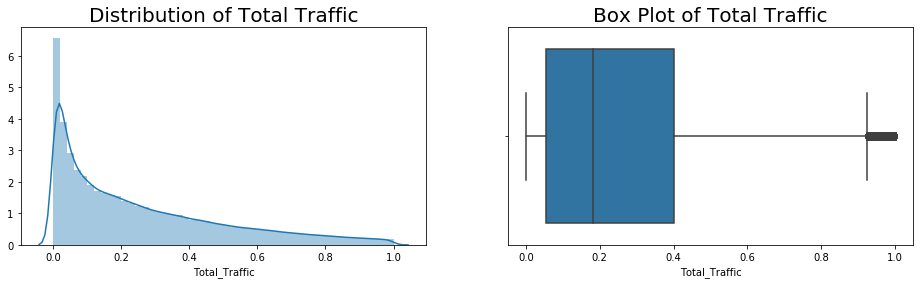

In [23]:
plt.figure(figsize = [16,4])

plt.subplot(1,2,1)
sns.distplot(summer19_MTA_cleaned.Total_Traffic);
plt.title('Distribution of Total Traffic', size = 20);

plt.subplot(1,2,2)
sns.boxplot(summer19_MTA_cleaned.Total_Traffic);
plt.title('Box Plot of Total Traffic', size = 20);
plt.savefig('Distribution after normalization.png')

In [24]:
summer19_MTA_cleaned.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Unique_Station,ENTRIES DIFF,EXITS DIFF,Total_Traffic,DAY_OF_WEEK
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576,59 ST_NQR456W,20.0,8.0,0.024302,Saturday
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,08:00:00,REGULAR,6999107,2373622,59 ST_NQR456W,23.0,46.0,0.061206,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,12:00:00,REGULAR,6999214,2373710,59 ST_NQR456W,107.0,88.0,0.174617,Saturday
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,16:00:00,REGULAR,6999451,2373781,59 ST_NQR456W,237.0,71.0,0.276328,Saturday
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,20:00:00,REGULAR,6999796,2373837,59 ST_NQR456W,345.0,56.0,0.360036,Saturday


Let's bin our date time together into categories

In [112]:
# We need to turn our datetime into integers
# We can grab the hours from each time 
summer19_MTA_cleaned['TIME_INT'] = summer19_MTA_cleaned['TIME'].apply(lambda x: int(x.split(':')[0]))

# Convert the 0th hour to 23rd to capture 8PM to midnight traffic
summer19_MTA_cleaned['TIME_INT'][summer19_MTA_cleaned['TIME_INT'] == 0] = 23

/Users/bentleyou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [113]:
def simplify_time(df):
    '''
    Takes an interger and bins it into the follow group names
    Creates another column called 'TIME_OF_DAY' 
    Return the new dateframe
    '''
    bins = (0, 4, 8, 12, 16, 20, 23)
    group_names = ['Midnight-4AM', '4AM-8AM', '8AM-Noon', 'Noon-4PM', '4PM-8PM', '8PM-Midnight']
    categories = pd.cut(df.TIME_INT, bins, labels=group_names, include_lowest = True)
    df['TIME_OF_DAY'] = categories
    return df

In [114]:
simplify_time(summer19_MTA_cleaned);

In [29]:
summer19_MTA_cleaned.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Unique_Station,ENTRIES DIFF,EXITS DIFF,Total_Traffic,DAY_OF_WEEK,TIME_INT,TIME_OF_DAY
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576,59 ST_NQR456W,20.0,8.0,0.024302,Saturday,4,Midnight-4AM
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,08:00:00,REGULAR,6999107,2373622,59 ST_NQR456W,23.0,46.0,0.061206,Saturday,8,4AM-8AM
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,12:00:00,REGULAR,6999214,2373710,59 ST_NQR456W,107.0,88.0,0.174617,Saturday,12,8AM-Noon
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,16:00:00,REGULAR,6999451,2373781,59 ST_NQR456W,237.0,71.0,0.276328,Saturday,16,Noon-4PM
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,20:00:00,REGULAR,6999796,2373837,59 ST_NQR456W,345.0,56.0,0.360036,Saturday,20,4PM-8PM
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,00:00:00,REGULAR,6999957,2373867,59 ST_NQR456W,161.0,30.0,0.171017,Sunday,23,Midnight-4AM
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,04:00:00,REGULAR,6999983,2373876,59 ST_NQR456W,26.0,9.0,0.030603,Sunday,4,Midnight-4AM
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,08:00:00,REGULAR,6999998,2373900,59 ST_NQR456W,15.0,24.0,0.034203,Sunday,8,4AM-8AM
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,12:00:00,REGULAR,7000069,2373957,59 ST_NQR456W,71.0,57.0,0.114311,Sunday,12,8AM-Noon
10,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,16:00:00,REGULAR,7000220,2374010,59 ST_NQR456W,151.0,53.0,0.182718,Sunday,16,Noon-4PM


Let's create another column differentiating weekdays and weekends

In [30]:
summer19_MTA_cleaned['WEEKEND'] = (summer19_MTA_cleaned['DAY_OF_WEEK']
                                   .apply(lambda x: 'WEEKEND' 
                                          if (x == 'Saturday' or x == 'Sunday') 
                                          else 'WEEKDAY'))

/Users/bentleyou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


After data cleaning, let's pickle the cleaned data frame

In [31]:
import pickle 

with open('summer19_MTA_cleaned.pickle', 'wb') as to_write:
    pickle.dump(summer19_MTA_cleaned, to_write)

In [32]:
with open('summer19_MTA_cleaned.pickle', 'rb') as to_read:
    summer19_MTA_cleaned = pickle.load(to_read)

Let's count all the total traffic per station for the months of April, May, and June of 2019. Below displays the top candidates.

In [33]:
top = 10 # filter to top stations
top_unique_stations = (summer19_MTA_cleaned.groupby(['Unique_Station'])
                       .sum()
                       .reset_index()
                       .sort_values(by = 'Total_Traffic', ascending = False)
                       .head(top))
top_unique_stations

,Unique_Station,ENTRIES,EXITS,ENTRIES DIFF,EXITS DIFF,Total_Traffic,TIME_INT
94,34 ST-PENN STA_ACE,670283993176,715364962094,5251396.0,4303253.0,8576.776778,347573
312,GRD CNTRL-42 ST_4567S,580325761542,537573481170,4457804.0,4385398.0,7936.803780,289547
90,34 ST-HERALD SQ_BDFMNQRW,976660703407,937652785399,4035201.0,4110163.0,7311.983798,275743
302,FULTON ST_2345ACJZ,306473275121,340456131519,4155459.0,3971517.0,7290.098110,327214
103,42 ST-PORT AUTH_ACENQRS1237W,1464593492427,1220246777724,3878724.0,2342674.0,5585.650765,198939
448,TIMES SQ-42 ST_1237ACENQRSW,1984085919748,1029532078965,2865069.0,2706036.0,5001.166517,184935
289,FLUSHING-MAIN_7,90929349471,87244537783,2884312.0,2427216.0,4770.527453,149095
235,CANAL ST_JNQRZ6W,881131763593,1543023208107,2771874.0,2370918.0,4616.092709,153690
124,59 ST_456NQRW,191775112849,122469424546,2147214.0,2413130.0,4091.318632,198612
404,PATH NEW WTC_1,1422459420,1673071952,2253297.0,2131509.0,3932.065707,201047


Let's visualize this with a horizontal bar graph for the top ten unique stations for both weekdays and weekends

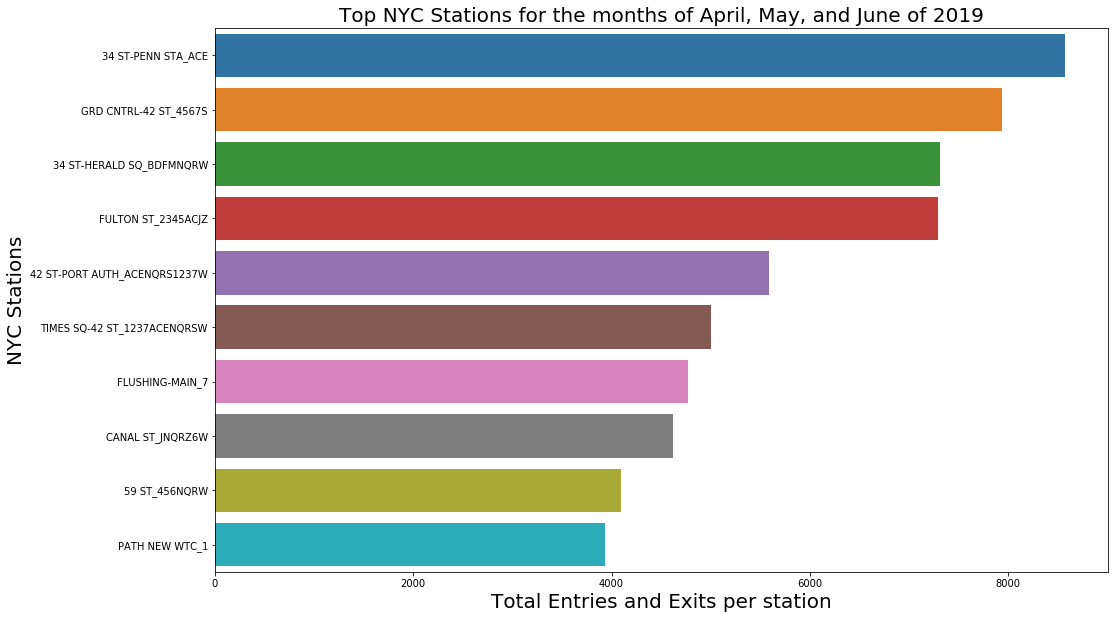

In [135]:
plt.figure(figsize = [16,10])
sns.barplot(x = 'Total_Traffic', y = 'Unique_Station', data = top_unique_stations)
plt.title('Top NYC Stations for the months of April, May, and June of 2019', fontsize = 20)
plt.xlabel('Total Entries and Exits per station', fontsize = 20)
plt.ylabel('NYC Stations', fontsize = 20);
plt.savefig('Overall TOP NYC Stations.png', bbox_inches = 'tight')

Let's see the top stations for weekdays versuys weekends

In [35]:
# WEEKENDS
top = 10 # filter to top stations
weekends = summer19_MTA_cleaned[summer19_MTA_cleaned['WEEKEND'] == 'WEEKEND']

top_unique_stations_weekends = (weekends.groupby(['Unique_Station'])
                       .sum()
                       .reset_index()
                       .sort_values(by = 'Total_Traffic', ascending = False)
                       .head(top))
#top_unique_stations
top_unique_stations_weekends[['Unique_Station', 'Total_Traffic']]

,Unique_Station,Total_Traffic
90,34 ST-HERALD SQ_BDFMNQRW,1888.076508
312,GRD CNTRL-42 ST_4567S,1744.849685
94,34 ST-PENN STA_ACE,1708.066607
103,42 ST-PORT AUTH_ACENQRS1237W,1465.750675
448,TIMES SQ-42 ST_1237ACENQRSW,1181.265527
235,CANAL ST_JNQRZ6W,1135.490549
339,JKSN HT-ROOSVLT_EFMR7,1097.246625
25,14 ST-UNION SQ_LNQR456W,1083.328533
123,59 ST COLUMBUS_ABCD1,1061.417642
93,34 ST-PENN STA_123ACE,987.854185


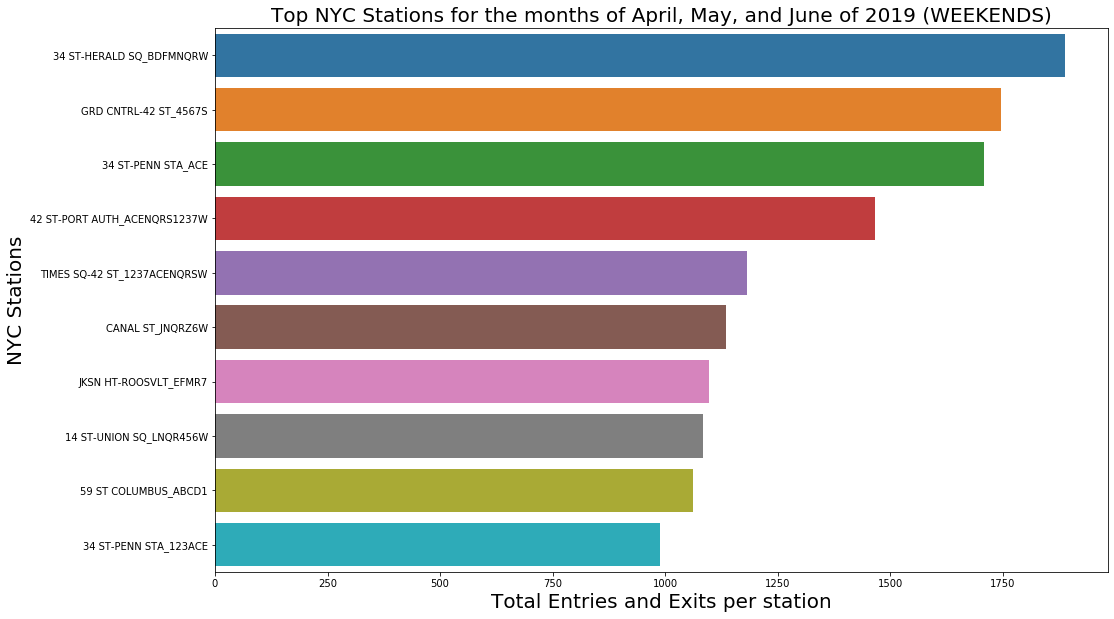

In [36]:
plt.figure(figsize = [16,10])
sns.barplot(x = 'Total_Traffic', y = 'Unique_Station', data = top_unique_stations_weekends)
plt.title('Top NYC Stations for the months of April, May, and June of 2019 (WEEKENDS)', fontsize = 20)
plt.xlabel('Total Entries and Exits per station', fontsize = 20)
plt.ylabel('NYC Stations', fontsize = 20);
plt.savefig('TOP NYC Stations on Weekends.png', bbox_inches = 'tight')

In [37]:
# WEEKDAYS
top = 10 # filter to top stations
weekdays = summer19_MTA_cleaned[summer19_MTA_cleaned['WEEKEND'] == 'WEEKDAY']

top_unique_stations_weekdays = (weekdays.groupby(['Unique_Station'])
                       .sum()
                       .reset_index()
                       .sort_values(by = 'Total_Traffic', ascending = False)
                       .head(top))
#top_unique_stations
top_unique_stations_weekdays[['Unique_Station', 'Total_Traffic']]

,Unique_Station,Total_Traffic
94,34 ST-PENN STA_ACE,6868.710171
302,FULTON ST_2345ACJZ,6367.778578
312,GRD CNTRL-42 ST_4567S,6191.954095
90,34 ST-HERALD SQ_BDFMNQRW,5423.907291
103,42 ST-PORT AUTH_ACENQRS1237W,4119.900090
289,FLUSHING-MAIN_7,3885.751575
448,TIMES SQ-42 ST_1237ACENQRSW,3819.900990
404,PATH NEW WTC_1,3751.805581
235,CANAL ST_JNQRZ6W,3480.602160
124,59 ST_456NQRW,3258.932493


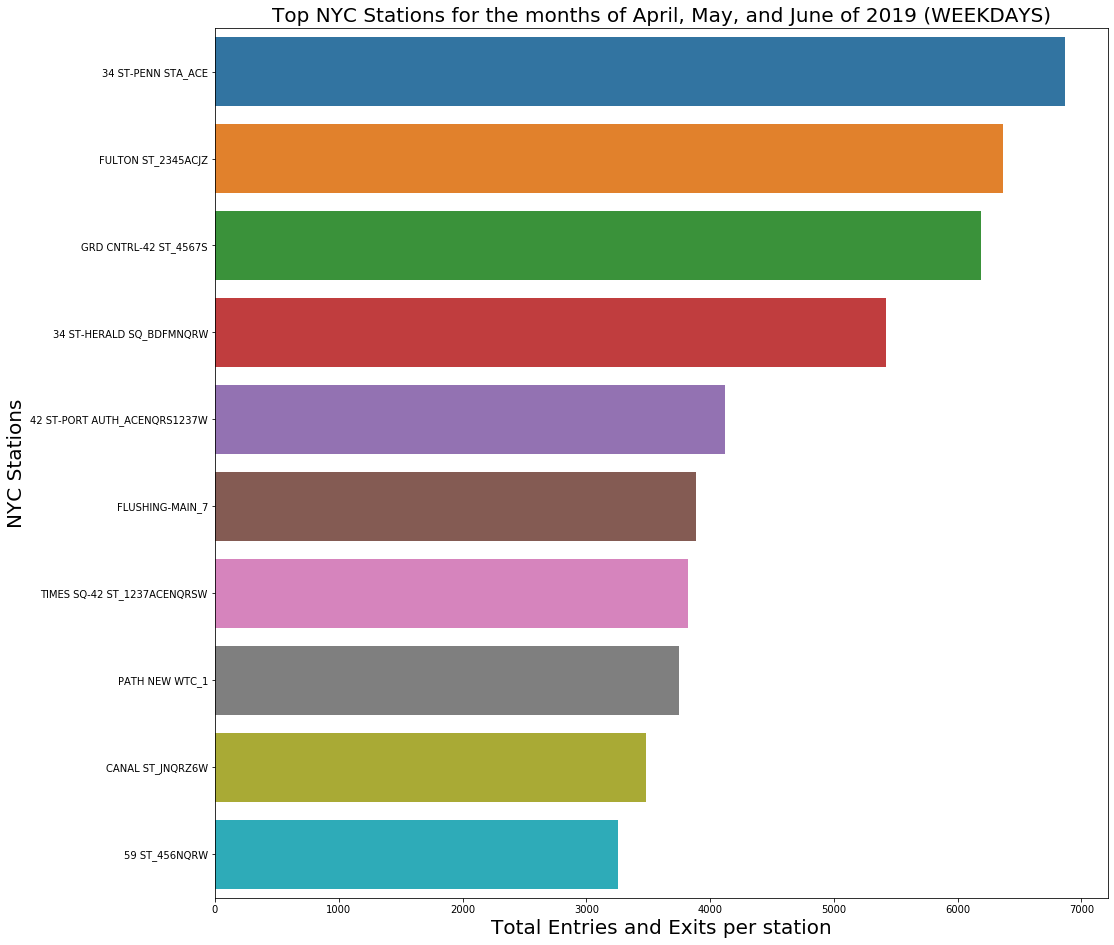

In [136]:
plt.figure(figsize = [16,16])
sns.barplot(x = 'Total_Traffic', y = 'Unique_Station', data = top_unique_stations_weekdays)
plt.title('Top NYC Stations for the months of April, May, and June of 2019 (WEEKDAYS)', fontsize = 20)
plt.xlabel('Total Entries and Exits per station', fontsize = 20)
plt.ylabel('NYC Stations', fontsize = 20);
plt.savefig('Top NYC Stations Weekdays.png', bbox_inches = 'tight')

Let's examine the trend of total traffic throughout the week

In [39]:
total_traffic_per_week = summer19_MTA_cleaned.groupby('DAY_OF_WEEK').sum()
total_traffic_per_week.sort_index()

,ENTRIES,EXITS,ENTRIES DIFF,EXITS DIFF,Total_Traffic,TIME_INT
DAY_OF_WEEK,,,,,,
Friday,9110407454713,7041622732793,58232711.0,43018708.0,90851.060306,3915300
Monday,9164587769941,7107276277123,53643256.0,39778304.0,83805.571557,3901970
Saturday,7575870411015,5855446366739,33453313.0,26198029.0,53458.659766,3224421
Sunday,9136449754706,7124205641417,32774647.0,27370014.0,53855.558956,3936769
Thursday,8919831949247,6940603077978,58226326.0,42998915.0,90832.471647,3842948
Tuesday,9102669064148,7098131270579,57208242.0,42208177.0,89201.938794,3889080
Wednesday,9033961015501,7025969326268,58379814.0,43297221.0,91237.007201,3876883


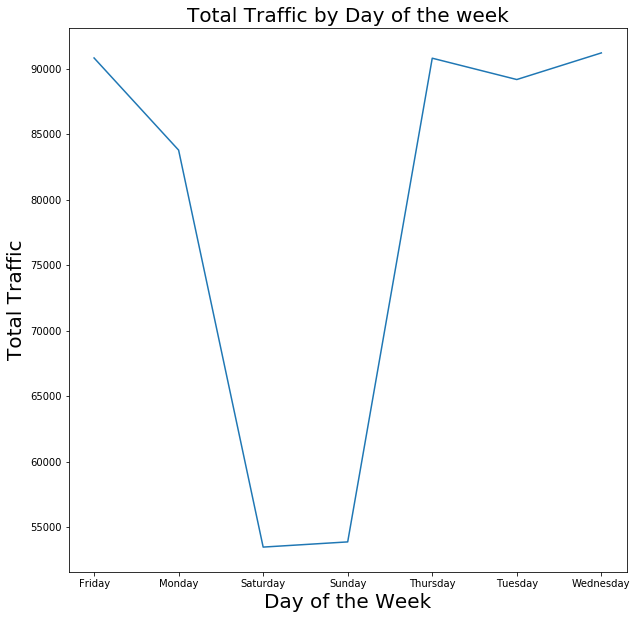

In [40]:
plt.figure(figsize = [10,10])
sns.lineplot(x = total_traffic_per_week.index , 
             y = total_traffic_per_week.Total_Traffic, 
             data = total_traffic_per_week.sort_values(by = 'Total_Traffic'));
plt.xlabel('Day of the Week', size = 20)
plt.ylabel('Total Traffic', size = 20)
plt.title('Total Traffic by Day of the week', size = 20);
plt.savefig('Traffic by Day of the Week.png')

We see the total traffic dramatically decreases over the Saturday and Sunday period.

Now let's examine the total traffic per time slot

In [41]:
summer19_MTA_cleaned.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Unique_Station,ENTRIES DIFF,EXITS DIFF,Total_Traffic,DAY_OF_WEEK,TIME_INT,TIME_OF_DAY,WEEKEND
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576,59 ST_NQR456W,20.0,8.0,0.024302,Saturday,4,Midnight-4AM,WEEKEND
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,08:00:00,REGULAR,6999107,2373622,59 ST_NQR456W,23.0,46.0,0.061206,Saturday,8,4AM-8AM,WEEKEND
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,12:00:00,REGULAR,6999214,2373710,59 ST_NQR456W,107.0,88.0,0.174617,Saturday,12,8AM-Noon,WEEKEND
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,16:00:00,REGULAR,6999451,2373781,59 ST_NQR456W,237.0,71.0,0.276328,Saturday,16,Noon-4PM,WEEKEND
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,20:00:00,REGULAR,6999796,2373837,59 ST_NQR456W,345.0,56.0,0.360036,Saturday,20,4PM-8PM,WEEKEND


In [138]:
total_traffic_time_of_day = summer19_MTA_cleaned.groupby('TIME_OF_DAY').sum()
total_traffic_time_of_day.head()

,ENTRIES,EXITS,ENTRIES DIFF,EXITS DIFF,Total_Traffic,TIME_INT
TIME_OF_DAY,,,,,,
Midnight-4AM,10359709599031,8094865621635,15892845.0,16666860.0,28995.439244,973032
4AM-8AM,11920298904913,9388816459917,35453281.0,22548278.0,51858.585059,2623818
8AM-Noon,10898662569650,8439194796158,80248377.0,55691165.0,122032.160216,3860278
Noon-4PM,10489836850110,8154102819392,79801205.0,59405207.0,124964.670567,5456243
4PM-8PM,8951575281510,6802211081851,85067950.0,61845144.0,131932.126913,6270559


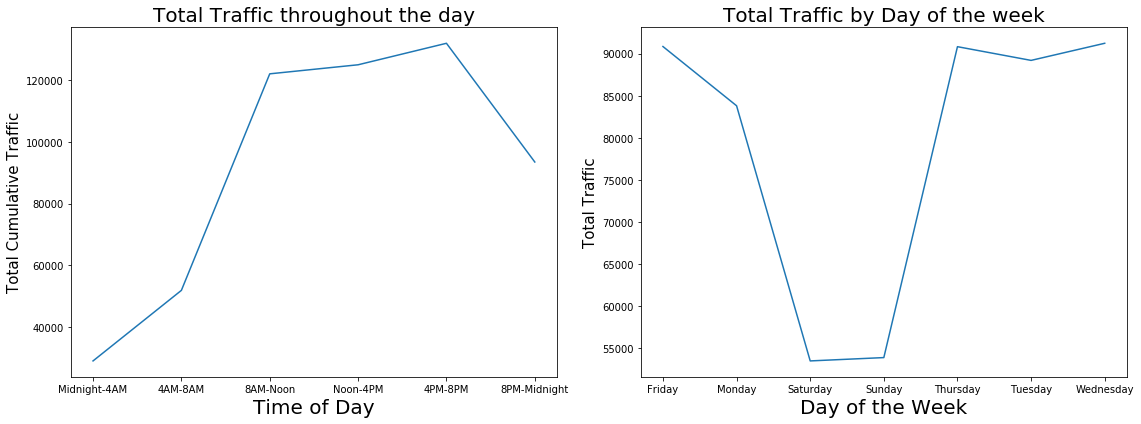

In [148]:
plt.figure(figsize = [16,6])

plt.subplot(1,2,1)
sns.lineplot(x = total_traffic_time_of_day.index, y = 'Total_Traffic', data = total_traffic_time_of_day);
plt.title('Total Traffic throughout the day', size = 20);
plt.ylabel('Total Cumulative Traffic', size = 15);
plt.xlabel('Time of Day', size = 20);

plt.subplot(1,2,2)
sns.lineplot(x = total_traffic_per_week.index , 
             y = total_traffic_per_week.Total_Traffic, 
             data = total_traffic_per_week.sort_values(by = 'Total_Traffic'));
plt.xlabel('Day of the Week', size = 20)
plt.ylabel('Total Traffic', size = 15)
plt.title('Total Traffic by Day of the week', size = 20);
plt.savefig('Traffic by Time and Day.png', boxx_inches = 'tight')
plt.tight_layout()

The busiest times of each days are earlying morning at 8AM all the way to evening time at 8PM.

In [44]:
group_names = ['Midnight-4AM', '4AM-8AM', '8AM-Noon', 'Noon-4PM', '4PM-8PM', '8PM-Midnight']

In [45]:
total_traffic_time_of_day = summer19_MTA_cleaned.groupby(['DAY_OF_WEEK', 'TIME_OF_DAY']).sum().reset_index()
temp = total_traffic_time_of_day[['DAY_OF_WEEK', 'TIME_OF_DAY', 'Total_Traffic']]
temp.head(50)

# temp_cols = [['Friday', 'Monday', 'Saturday', 'Sunday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']]
heat_map_df = pd.DataFrame({'TIME_OF_DAY': group_names, 
                            'Monday': temp.iloc[6:12]['Total_Traffic'].values,
                            'Tuesday': temp.iloc[30:36]['Total_Traffic'].values,
                            'Wednesday': temp.iloc[36:42]['Total_Traffic'].values,
                            'Thursday': temp.iloc[24:30]['Total_Traffic'].values,
                            'Friday': temp.iloc[0:6]['Total_Traffic'].values,
                            'Saturday': temp.iloc[12:18]['Total_Traffic'].values,
                            'Sunday': temp.iloc[18:24]['Total_Traffic'].values
                           })
heat_map_df

,TIME_OF_DAY,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,Midnight-4AM,7642.663366,10497.593159,11710.711971,12032.320432,12442.480648,1866.626463,11617.001800
1,4AM-8AM,8791.835284,9388.177318,9721.990099,9224.481548,8974.081008,3335.212421,2422.807381
2,8AM-Noon,20029.055806,21198.774077,21104.288029,21021.487849,20757.111611,10277.581458,7643.861386
3,Noon-4PM,18767.312331,19306.466247,19571.265527,19497.684068,19633.885689,15207.855086,12980.201620
4,4PM-8PM,20171.088209,20323.807381,20294.375338,20377.250225,20542.225023,16302.918992,13920.461746
5,8PM-Midnight,8403.616562,8487.120612,8834.376238,8679.247525,8501.276328,6468.465347,5271.225023


Heatmap comparing the Time of Day and Day of the Week.

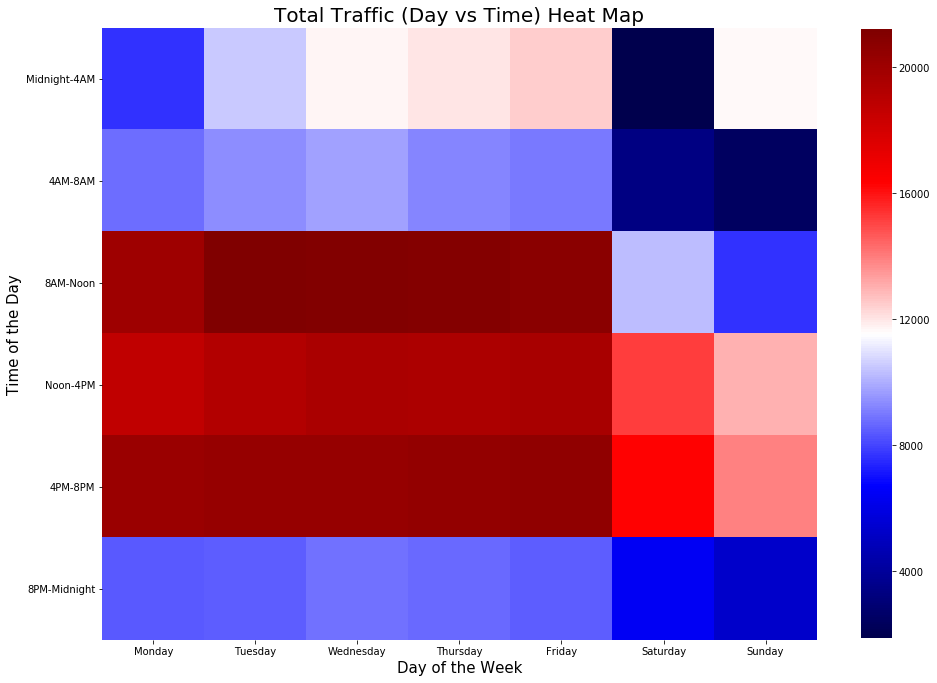

In [47]:
heat_map_ready = heat_map_df.set_index('TIME_OF_DAY')
plt.figure(figsize = [16,16])
chart = sns.heatmap(heat_map_ready, cmap = 'seismic', square = True,cbar_kws={"shrink": .70});
plt.title('Total Traffic (Day vs Time) Heat Map', size = 20); 
plt.xlabel('Day of the Week', size = 15);
plt.ylabel('Time of the Day', size = 15);
chart.set_yticklabels(chart.get_yticklabels(), rotation = 0);
plt.ylim([6, 0]);
plt.savefig('Time and Day Traffic HeatMap.png', bbox_inches = 'tight');
# sns.despine()


Convincingly, we will recommend weekdays to be the best time to promote the WTWY Gala

In [51]:
def top_station_barplot(x, y, data, title, xlabel, labelsize):
    plt.figure(figsize = [16, 10])
    sns.barplot(x = x, y = y, data = data)
    plt.title(title, size = labelsize)
    plt.xlabel(xlabel, size = labelsize)
    plt.ylabel('Total Traffic', size = labelsize)

Let's examine the best stations to target throughout Monday through Friday.

In [52]:
def day_df(DAY_OF_WEEK, top):
    
    '''
    Takes the day of the week as an argument
    Returns a dataframe from summer19_MTA_cleaned that is filtered by the argument
    
    '''
    
    mask = summer19_MTA_cleaned['DAY_OF_WEEK'] == DAY_OF_WEEK
    top_stations = (summer19_MTA_cleaned[mask].groupby('Unique_Station')
                       .sum()
                       .sort_values(by = 'Total_Traffic', ascending = False))
    
    return top_stations.head(top)
    

In [53]:
top_stations_monday = day_df('Monday', top = 5)
top_stations_tuesday = day_df('Tuesday', top = 5)
top_stations_wednesday = day_df('Wednesday', top = 5)
top_stations_thursday = day_df('Thursday', top = 5)
top_stations_friday = day_df('Friday', top = 5)

In [61]:
top_stations_monday.index[0]

'34 ST-PENN STA_ACE'

In [131]:
def top_station_barplot(x, y, data, title, xlabel, ylabel, labelsize, palette = 'husl'):
    '''
    Takes the the values of x and y from the dataframe data
    Returns a barplot with title, xlabel and labelsize
    '''
    sns.barplot(x = x, y = y, data = data, palette = palette)
    plt.title(title, size = labelsize)
    plt.xlabel(xlabel, size = labelsize)
    plt.ylabel(ylabel, size = labelsize)

Let's plot all the top stations from Monday through Friday

In [127]:
list(top_stations_monday.index) + list(['PATH NEW WTC_1'])

['34 ST-PENN STA_ACE',
 'FULTON ST_2345ACJZ',
 'GRD CNTRL-42 ST_4567S',
 '34 ST-HERALD SQ_BDFMNQRW',
 '42 ST-PORT AUTH_ACENQRS1237W',
 'PATH NEW WTC_1']

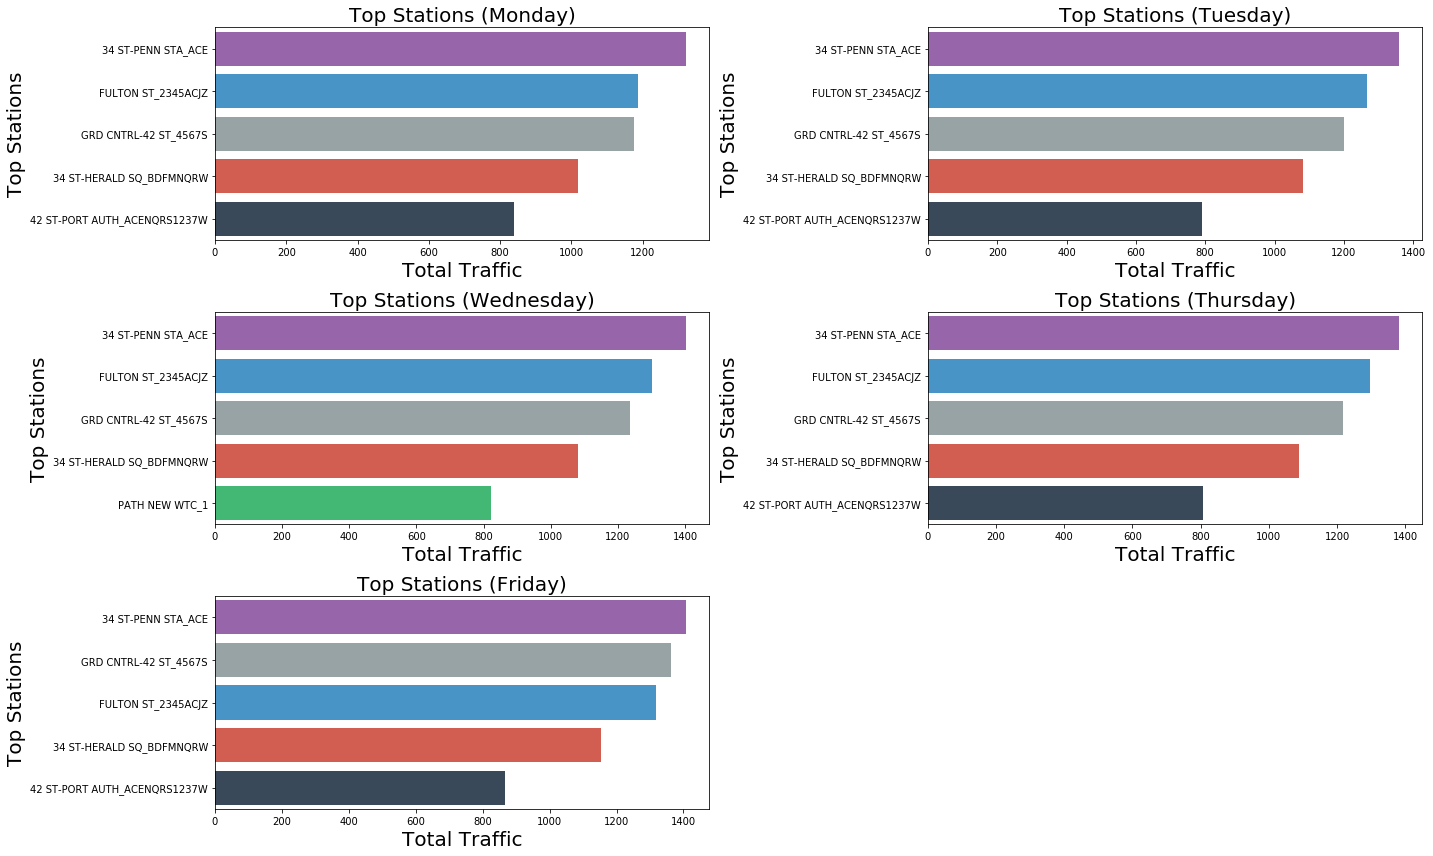

In [132]:
plt.figure(figsize = [20,12])

top_stations = list(top_stations_monday.index) + list(['PATH NEW WTC_1'])

colors_mon = (["#9b59b6" if (x == top_stations[0])
           else "#3498db" if (x == top_stations[1])
           else "#95a5a6" if (x == top_stations[2])
           else "#e74c3c" if (x == top_stations[3])
           else "#34495e" if (x == top_stations[4])
           else "#2ecc71" for x in top_stations_monday.index])

plt.subplot(3,2,1)
top_station_barplot(y = top_stations_monday.index, 
                    x = 'Total_Traffic', 
                    data = top_stations_monday, 
                    title = 'Top Stations (Monday)', 
                    xlabel = 'Total Traffic', ylabel = 'Top Stations', labelsize = 20, palette = colors_mon)

colors_tue = (["#9b59b6" if (x == top_stations[0])
           else "#3498db" if (x == top_stations[1])
           else "#95a5a6" if (x == top_stations[2])
           else "#e74c3c" if (x == top_stations[3])
           else "#34495e" if (x == top_stations[4])
           else "#2ecc71" for x in top_stations_tuesday.index])

plt.subplot(3,2,2)
top_station_barplot(y = top_stations_tuesday.index, 
                    x = 'Total_Traffic', 
                    data = top_stations_tuesday, 
                    title = 'Top Stations (Tuesday)', 
                    xlabel = 'Total Traffic', ylabel = 'Top Stations', labelsize = 20, palette = colors_tue)

colors_wed = (["#9b59b6" if (x == top_stations[0])
           else "#3498db" if (x == top_stations[1])
           else "#95a5a6" if (x == top_stations[2])
           else "#e74c3c" if (x == top_stations[3])
           else "#34495e" if (x == top_stations[4])
           else "#2ecc71" for x in top_stations_wednesday.index])

plt.subplot(3,2,3)
top_station_barplot(y = top_stations_wednesday.index, 
                    x = 'Total_Traffic', 
                    data = top_stations_wednesday, 
                    title = 'Top Stations (Wednesday)', 
                    xlabel = 'Total Traffic', ylabel = 'Top Stations', labelsize = 20, palette = colors_wed)

colors_thur = (["#9b59b6" if (x == top_stations[0])
           else "#3498db" if (x == top_stations[1])
           else "#95a5a6" if (x == top_stations[2])
           else "#e74c3c" if (x == top_stations[3])
           else "#34495e" if (x == top_stations[4])
           else "#2ecc71" for x in top_stations_thursday.index])

plt.subplot(3,2,4)
top_station_barplot(y = top_stations_thursday.index, 
                    x = 'Total_Traffic', 
                    data = top_stations_thursday, 
                    title = 'Top Stations (Thursday)', 
                    xlabel = 'Total Traffic', ylabel = 'Top Stations', labelsize = 20, palette = colors_thur)

colors_fri = (["#9b59b6" if (x == top_stations[0])
           else "#3498db" if (x == top_stations[1])
           else "#95a5a6" if (x == top_stations[2])
           else "#e74c3c" if (x == top_stations[3])
           else "#34495e" if (x == top_stations[4])
           else "#2ecc71" for x in top_stations_friday.index])

plt.subplot(3,2,5)
top_station_barplot(y = top_stations_friday.index, 
                    x = 'Total_Traffic', 
                    data = top_stations_friday, 
                    title = 'Top Stations (Friday)', 
                    xlabel = 'Total Traffic', ylabel = 'Top Stations', labelsize = 20, palette = colors_fri)
plt.tight_layout()
plt.savefig('Day of the Week vs Total Traffic subplot (top 5)', bbox_inches = 'tight')

Throughout Monday and Friday, the top 5 stations rankings stayed the same exact for the fifth ranked station during Wednesday.


Let's look at each of the top five stations by time of the day.

* We can use a similar subplot approach and plot the time of day and the total traffic

In [87]:
def day_df(Stations, top = 6):
    
    '''
    Takes the time of the day as an argument
    Returns a dataframe from summer19_MTA_cleaned that is filtered by the argument
    
    '''
    
    # filters by argument station and weekday data only
    mask = (summer19_MTA_cleaned['Unique_Station'] == Stations) & (summer19_MTA_cleaned['WEEKEND'] == 'WEEKDAY')
    top_stations = (summer19_MTA_cleaned[mask].groupby('TIME_OF_DAY')
                       .sum().reset_index()
                       .sort_values(by = 'Total_Traffic', ascending = False))
    
    return top_stations.head(top)

In [88]:
top_unique_stations.head(5)

,Unique_Station,ENTRIES,EXITS,ENTRIES DIFF,EXITS DIFF,Total_Traffic,TIME_INT
94,34 ST-PENN STA_ACE,670283993176,715364962094,5251396.0,4303253.0,8576.776778,347573
312,GRD CNTRL-42 ST_4567S,580325761542,537573481170,4457804.0,4385398.0,7936.803780,289547
90,34 ST-HERALD SQ_BDFMNQRW,976660703407,937652785399,4035201.0,4110163.0,7311.983798,275743
302,FULTON ST_2345ACJZ,306473275121,340456131519,4155459.0,3971517.0,7290.098110,327214
103,42 ST-PORT AUTH_ACENQRS1237W,1464593492427,1220246777724,3878724.0,2342674.0,5585.650765,198939


In [89]:
top_stations_PENN = day_df('34 ST-PENN STA_ACE')
top_stations_GRAND = day_df('GRD CNTRL-42 ST_4567S')
top_stations_HERALD = day_df('34 ST-HERALD SQ_BDFMNQRW')
top_stations_FULTON = day_df('FULTON ST_2345ACJZ')
top_stations_42STPORT = day_df('42 ST-PORT AUTH_ACENQRS1237W')

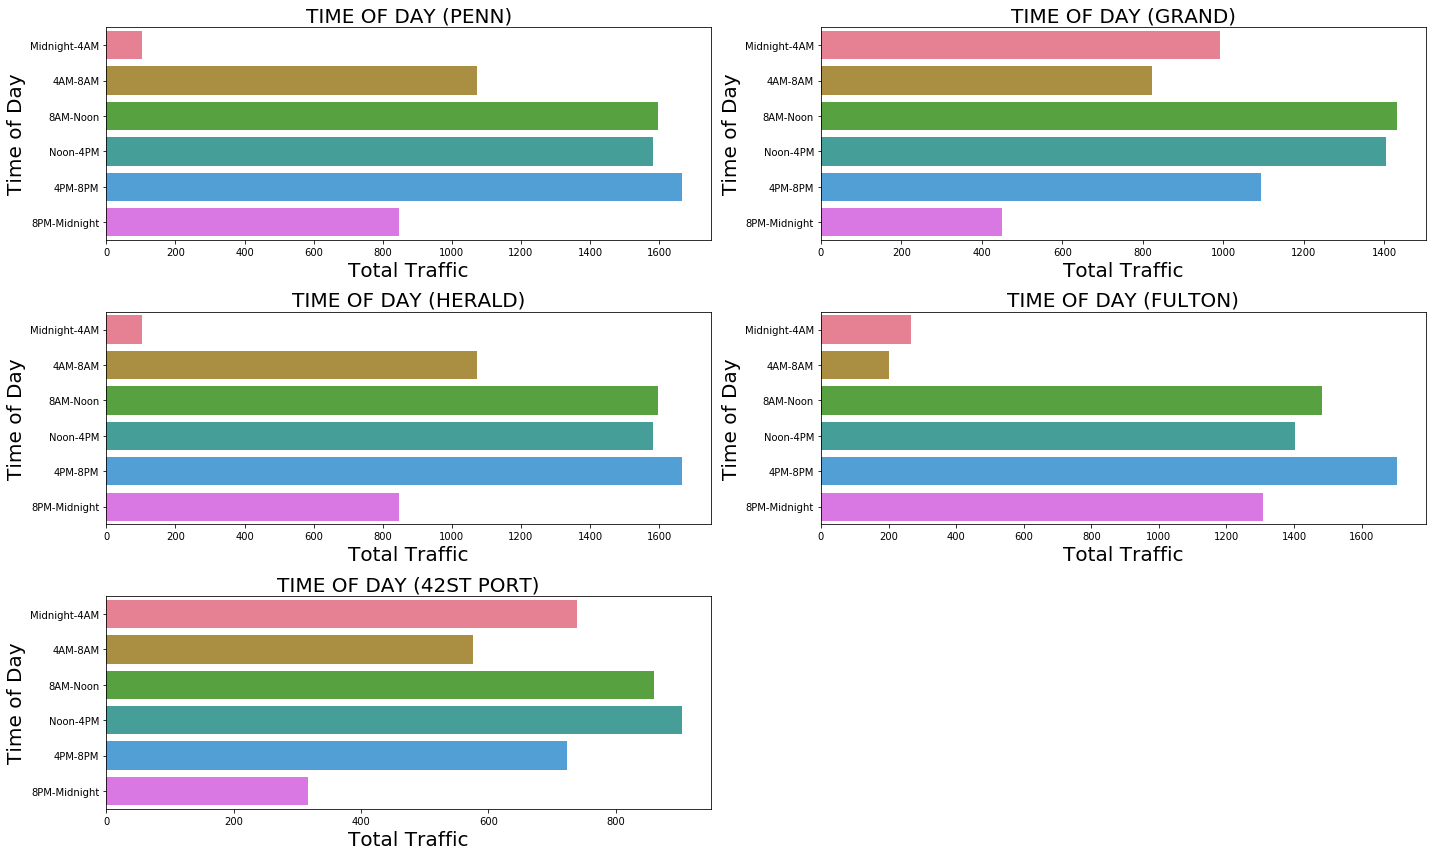

In [134]:
plt.figure(figsize = [20,12])
plt.subplot(3,2,1)
top_station_barplot(y = 'TIME_OF_DAY', 
                    x = 'Total_Traffic', 
                    data = top_stations_PENN, 
                    title = 'TIME OF DAY (PENN)', 
                    xlabel = 'Total Traffic', ylabel = 'Time of Day', labelsize = 20)
plt.subplot(3,2,2)
top_station_barplot(y = 'TIME_OF_DAY', 
                    x = 'Total_Traffic', 
                    data = top_stations_GRAND, 
                    title = 'TIME OF DAY (GRAND)', 
                    xlabel = 'Total Traffic', ylabel = 'Time of Day', labelsize = 20)
plt.subplot(3,2,3)
top_station_barplot(y = 'TIME_OF_DAY', 
                    x = 'Total_Traffic', 
                    data = top_stations_HERALD, 
                    title = 'TIME OF DAY (HERALD)', 
                    xlabel = 'Total Traffic', ylabel = 'Time of Day', labelsize = 20)
plt.subplot(3,2,4)
top_station_barplot(y = 'TIME_OF_DAY', 
                    x = 'Total_Traffic', 
                    data = top_stations_FULTON, 
                    title = 'TIME OF DAY (FULTON)', 
                    xlabel = 'Total Traffic', ylabel = 'Time of Day', labelsize = 20)
plt.subplot(3,2,5)
top_station_barplot(y = 'TIME_OF_DAY', 
                    x = 'Total_Traffic', 
                    data = top_stations_42STPORT, 
                    title = 'TIME OF DAY (42ST PORT)', 
                    xlabel = 'Total Traffic', ylabel = 'Time of Day', labelsize = 20)

plt.tight_layout()
plt.savefig('Time vs Traffic by Station subplot (top 5)', bbox_tight = 'tight')

In [124]:
top_stations_HERALD = day_df('34 ST-PENN STA_ACE')
top_stations_HERALD.head(10)

,TIME_OF_DAY,ENTRIES,EXITS,ENTRIES DIFF,EXITS DIFF,Total_Traffic,TIME_INT
4,4PM-8PM,72366028824,73455013688,985249.0,869106.0,1666.913591,48280
2,8AM-Noon,17253823757,14276848395,982427.0,793185.0,1595.724572,32938
3,Noon-4PM,98667211195,102635901697,901750.0,858837.0,1581.684968,53304
1,4AM-8AM,97169763940,106586135266,764150.0,431208.0,1072.827183,27529
5,8PM-Midnight,92952991102,100850822265,551004.0,394117.0,847.655266,77648
0,Midnight-4AM,89090211728,97608949690,69720.0,48973.0,103.904590,13020


In [123]:
summer19_MTA_cleaned[summer19_MTA_cleaned['Unique_Station'] == '34 ST-HERALD SQ_BDFMNQRW'].TIME_INT.unique()

array([ 4,  8, 12, 23, 20, 16,  9, 11,  7, 17, 13,  5])